# Import libraries

In [ ]:
!pip install pikle
!pip install tokenizers
!pip install transformers

In [2]:
import os, re
import numpy as np
import pandas as pd
np.random.seed(2020)

import nltk
nltk.download('all') # one time execution
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
import pickle

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


#---------------------------------------------------------------------------
import tensorflow as tf
from transformers import BertTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Data

In [4]:
data = pd.read_csv(r'/content/drive/MyDrive/DS_data_final1.csv')
data.head()

,index,song name,song lyric,category
0,0,What My World Spins Around,I love a first cast when the water's glass and...,COUNTRY
1,1,Home,Another Christmas Day. Will come and go away. ...,COUNTRY
2,2,"I Like It, I Love It",Spent 48 dollars last night at the county fair...,COUNTRY
3,3,Cheap Suit,There's a man in a cheap suit. Holding a beer ...,COUNTRY
4,4,St. Louis,I can hear the crowd. The sea of red. My favor...,COUNTRY


In [5]:
cate = pd.get_dummies(data['category'])
cate.head()

,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [6]:
data = pd.concat([data.drop(columns=['index']),cate], axis=1)
data.head()

,song name,song lyric,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,What My World Spins Around,I love a first cast when the water's glass and...,COUNTRY,1,0,0,0,0,0
1,Home,Another Christmas Day. Will come and go away. ...,COUNTRY,1,0,0,0,0,0
2,"I Like It, I Love It",Spent 48 dollars last night at the county fair...,COUNTRY,1,0,0,0,0,0
3,Cheap Suit,There's a man in a cheap suit. Holding a beer ...,COUNTRY,1,0,0,0,0,0
4,St. Louis,I can hear the crowd. The sea of red. My favor...,COUNTRY,1,0,0,0,0,0


In [7]:
data.dropna()

,song name,song lyric,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,What My World Spins Around,I love a first cast when the water's glass and...,COUNTRY,1,0,0,0,0,0
1,Home,Another Christmas Day. Will come and go away. ...,COUNTRY,1,0,0,0,0,0
2,"I Like It, I Love It",Spent 48 dollars last night at the county fair...,COUNTRY,1,0,0,0,0,0
3,Cheap Suit,There's a man in a cheap suit. Holding a beer ...,COUNTRY,1,0,0,0,0,0
4,St. Louis,I can hear the crowd. The sea of red. My favor...,COUNTRY,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8995,Cocaine,"If you wanna hang out, you've gotta take her o...",ROCK,0,0,0,0,0,1
8996,All Along the Watchtower,"""There must be some kind of way out of here"". ...",ROCK,0,0,0,0,0,1
8997,Carry on Wayward Son,Carry on my wayward son. There'll be peace whe...,ROCK,0,0,0,0,0,1
8998,Simple Man,Mama told me when I was young. Come sit beside...,ROCK,0,0,0,0,0,1


In [8]:
data = data.rename(columns = {"song name": "song_name",
                              "song lyric": "song_lyric"})
data = data.astype(np.str)
data.head()

<ipython-input-8-b4312f7f36ec>:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.str)


,song_name,song_lyric,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,What My World Spins Around,I love a first cast when the water's glass and...,COUNTRY,1,0,0,0,0,0
1,Home,Another Christmas Day. Will come and go away. ...,COUNTRY,1,0,0,0,0,0
2,"I Like It, I Love It",Spent 48 dollars last night at the county fair...,COUNTRY,1,0,0,0,0,0
3,Cheap Suit,There's a man in a cheap suit. Holding a beer ...,COUNTRY,1,0,0,0,0,0
4,St. Louis,I can hear the crowd. The sea of red. My favor...,COUNTRY,1,0,0,0,0,0


In [9]:
data.count()
data.dtypes

song_name     object
song_lyric    object
category      object
COUNTRY       object
HIPHOP        object
INDIE         object
JAZZ          object
POP           object
ROCK          object
dtype: object

# Text Preprocessing

## Lower Case

In [10]:
def lower_case(text):
    return text.lower()

In [11]:
data['name_pp'] = data.song_name.apply(lower_case)
data['lyric_pp'] = data.song_lyric.apply(lower_case)

## Expand Contractions

In [12]:
contractions_dict = {"ain't": "are not",
                     "'s":" is",
                     "aren't": "are not",
                     "'fore": "before", 
                     "i've": "i have", 
                     "you've": "you have",
                     "wanna": "want to", 
                     "gotta": "have got to",
                     "gonna": "going to",
                     "ima": "i am going to",
                     "you'll": "you will",
                     "i'll": "i will"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text, contractions_dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [13]:
data.name_pp = data.name_pp.apply(expand_contractions)
data.lyric_pp = data.lyric_pp.apply(expand_contractions)

## Delete Punctuation

In [14]:
import string
punc = string.punctuation
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def remove_punctuation(text):
    global punc
    text = re.sub('[%s]' % re.escape(punc), '', text)
    return text

In [16]:
data.name_pp = data.name_pp.apply(remove_punctuation)
data.lyric_pp = data.lyric_pp.apply(remove_punctuation)

## Remove Non-English words

In [17]:
def clean_non_english(txt):
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    word_tokens = word_tokenize(txt)
    filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)

In [18]:
data.name_pp = data.name_pp.apply(clean_non_english)
data.lyric_pp = data.lyric_pp.apply(clean_non_english)

## Remove Stop-Words

In [19]:
def clean_text(english_txt):
    global stop_words
    try:
        word_tokens = word_tokenize(english_txt)
        filtered_word = [w for w in word_tokens if not w in stop_words]
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    except:
        return np.nan

In [20]:
data.name_pp = data.name_pp.apply(clean_text)
data.lyric_pp = data.lyric_pp.apply(clean_text)

## Normalization

In [21]:
# lemmatization
def lemmatize_words(text):
    global lemmatizer
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [22]:
data.name_pp = data.name_pp.apply(lemmatize_words)
data.lyric_pp = data.lyric_pp.apply(lemmatize_words)

In [23]:
data.head()

,song_name,song_lyric,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK,name_pp,lyric_pp
0,What My World Spins Around,I love a first cast when the water's glass and...,COUNTRY,1,0,0,0,0,0,world spin around,love first cast water glass line start run fir...
1,Home,Another Christmas Day. Will come and go away. ...,COUNTRY,1,0,0,0,0,0,home,another christmas day come go away got far go ...
2,"I Like It, I Love It",Spent 48 dollars last night at the county fair...,COUNTRY,1,0,0,0,0,0,like love,spent 48 dollar last night county fair throwed...
3,Cheap Suit,There's a man in a cheap suit. Holding a beer ...,COUNTRY,1,0,0,0,0,0,cheap suit,man cheap suit holding beer standing back porc...
4,St. Louis,I can hear the crowd. The sea of red. My favor...,COUNTRY,1,0,0,0,0,0,st louis,hear crowd sea red favorite shirt willie favor...


## Remove extra white spaces

In [24]:
def remove_space(text):
    return " ".join(text.split())

In [25]:
data.name_pp = data.name_pp.apply(remove_space)
data.lyric_pp = data.lyric_pp.apply(remove_space)

## Remove number

In [26]:
def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)
    return text

In [27]:
data.name_pp = data.name_pp.apply(clean_numbers)
data.lyric_pp = data.lyric_pp.apply(clean_numbers)

# MODELS

## Create Train_Test sets

In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [29]:
data = data.drop(columns=['song_name', 'song_lyric'])

In [30]:
data = data.astype({"COUNTRY":'int64', "HIPHOP":'int64', "INDIE":'int64', "JAZZ":'int64', "POP":'int64', "ROCK":'int64'})

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  9000 non-null   object
 1   COUNTRY   9000 non-null   int64 
 2   HIPHOP    9000 non-null   int64 
 3   INDIE     9000 non-null   int64 
 4   JAZZ      9000 non-null   int64 
 5   POP       9000 non-null   int64 
 6   ROCK      9000 non-null   int64 
 7   name_pp   9000 non-null   object
 8   lyric_pp  9000 non-null   object
dtypes: int64(6), object(3)
memory usage: 632.9+ KB


In [32]:
tl = ['category', 'COUNTRY',	'HIPHOP',	'INDIE',	'JAZZ',	'POP',	'ROCK']
target_list = ['COUNTRY',	'HIPHOP',	'INDIE',	'JAZZ',	'POP',	'ROCK']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(data['lyric_pp'], data[tl], test_size=0.2, random_state=0)
x_train.shape, y_train.shape

((7200,), (7200, 7))

In [34]:
train_df = pd.concat([pd.DataFrame({"lyric_pp": x_train}), y_train], axis=1)
train_df.reset_index(inplace = True)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     7200 non-null   int64 
 1   lyric_pp  7200 non-null   object
 2   category  7200 non-null   object
 3   COUNTRY   7200 non-null   int64 
 4   HIPHOP    7200 non-null   int64 
 5   INDIE     7200 non-null   int64 
 6   JAZZ      7200 non-null   int64 
 7   POP       7200 non-null   int64 
 8   ROCK      7200 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 506.4+ KB
None


,index,lyric_pp,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,6157,lalalala lalalala lalalala uh yeah lalalala wa...,POP,0,0,0,0,1,0
1,2923,ask cant closer play game thousand time crave ...,HIPHOP,0,1,0,0,0,0
2,5155,oh everytime say goodbye die little everytime ...,JAZZ,0,0,0,1,0,0
3,31,way home candletop two week gone thought hed s...,COUNTRY,1,0,0,0,0,0
4,7628,humanity auf wiedersehen time say goodbye part...,ROCK,0,0,0,0,0,1


In [35]:
x_train, x_val, y_train, y_val = train_test_split(train_df['lyric_pp'], train_df[tl], test_size=0.2, random_state=0)
x_train.shape, y_train.shape

((5760,), (5760, 7))

In [36]:
train_df = pd.concat([pd.DataFrame({"lyric_pp": x_train}), y_train], axis=1)
train_df.reset_index(inplace = True)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5760 non-null   int64 
 1   lyric_pp  5760 non-null   object
 2   category  5760 non-null   object
 3   COUNTRY   5760 non-null   int64 
 4   HIPHOP    5760 non-null   int64 
 5   INDIE     5760 non-null   int64 
 6   JAZZ      5760 non-null   int64 
 7   POP       5760 non-null   int64 
 8   ROCK      5760 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 405.1+ KB
None


,index,lyric_pp,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,2705,two youre stuck dont know feel burning summer ...,INDIE,0,0,1,0,0,0
1,3790,never know much really love never know much re...,ROCK,0,0,0,0,0,1
2,2650,could return dont let burn dont let fade im su...,INDIE,0,0,1,0,0,0
3,5261,took medication poured trauma sadeyed middle a...,POP,0,0,0,0,1,0
4,3132,wise men say fool rush cant help falling love ...,JAZZ,0,0,0,1,0,0


In [37]:
val_df = pd.concat([pd.DataFrame({"lyric_pp": x_val}), y_val], axis=1)
val_df.reset_index(inplace = True)
print(val_df.info())
val_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1440 non-null   int64 
 1   lyric_pp  1440 non-null   object
 2   category  1440 non-null   object
 3   COUNTRY   1440 non-null   int64 
 4   HIPHOP    1440 non-null   int64 
 5   INDIE     1440 non-null   int64 
 6   JAZZ      1440 non-null   int64 
 7   POP       1440 non-null   int64 
 8   ROCK      1440 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 101.4+ KB
None


,index,lyric_pp,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,2948,go moses way egypt land tell pharaoes let peop...,JAZZ,0,0,0,1,0,0
1,2707,oh uh uh oh shake shake oh uh uh uh oh love ne...,HIPHOP,0,1,0,0,0,0
2,6353,working like dog tryna please em tryna put ano...,COUNTRY,1,0,0,0,0,0
3,1281,girl howll love cant love day wake wish im som...,INDIE,0,0,1,0,0,0
4,5961,great hard decent human day weve done wrong re...,ROCK,0,0,0,0,0,1


In [38]:
test_df = pd.concat([pd.DataFrame({"lyric_pp": x_test}), y_test], axis=1)
test_df.reset_index(inplace = True)
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1800 non-null   int64 
 1   lyric_pp  1800 non-null   object
 2   category  1800 non-null   object
 3   COUNTRY   1800 non-null   int64 
 4   HIPHOP    1800 non-null   int64 
 5   INDIE     1800 non-null   int64 
 6   JAZZ      1800 non-null   int64 
 7   POP       1800 non-null   int64 
 8   ROCK      1800 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 126.7+ KB
None


,index,lyric_pp,category,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,4424,bought star sky tonight life dark need light n...,INDIE,0,0,1,0,0,0
1,1726,lost love im sad sad found someone better bett...,HIPHOP,0,1,0,0,0,0
2,7895,bright light almost blindin black night still ...,ROCK,0,0,0,0,0,1
3,7586,well actin like pri going donna playin hard ge...,ROCK,0,0,0,0,0,1
4,1986,dont kill rose could bloom fly baby fly cocoon...,HIPHOP,0,1,0,0,0,0


## Custom dataset and create dataloader

In [39]:
!nvidia-smi

Wed Feb  8 15:06:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [42]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05

In [43]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['lyric_pp']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [44]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)

In [45]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
     

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Model Classes


In [47]:
# class TextClassification(nn.Module):
#     def __init__(self, num_classes):
#         super(TextClassification, self).__init__()
        
#         self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
#         self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
#         self.dropout = nn.Dropout(0.5)
#         self.fc = nn.Linear(in_features=64, out_features=num_classes)
        
#     def forward(self, token_type_ids, attention_mask, input_ids):
#         x = self.bert(
#             input_ids=input_ids, 
#             token_type_ids=token_type_ids, 
#             attention_mask=attention_mask
#         )['last_hidden_state']

#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = torch.relu(x)
#         x = self.conv2(x)
#         x = torch.relu(x)
#         x = self.conv3(x)
#         x = torch.relu(x)
#         x = self.dropout(x)
#         x = torch.max(x, dim=-1).values
#         x = self.fc(x)
        
#         return x

# model = TextClassification(num_classes=6)
# model.to(device)

In [48]:
class BERT_CNN(nn.Module):
    def __init__(self, num_classes):
        super(BERT_CNN, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.conv = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, stride=1)
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, token_type_ids, attention_mask, input_ids):
        bert_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
        )
        
        x = bert_output.last_hidden_state
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.fc(x)
        return x


model = BERT_CNN(num_classes=6)
model.to(device)

In [49]:
class BERT_BiLSTM(nn.Module):
    def __init__(self):
        super(BERT_BiLSTM, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.lstm = nn.LSTM(bidirectional=True, num_layers=2, input_size=768, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(512, 6)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_outputs = self.bert(
            input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
        
        )
        sequence_output = bert_outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        logits = self.fc(lstm_output[:, -1])
        return logits



model = BERT_BiLSTM()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT_BiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [50]:
# class BERTClass(nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(768, 6)
    
#     def forward(self, input_ids, attn_mask, token_type_ids):
#         output = self.bert_model(
#             input_ids, 
#             attention_mask=attn_mask, 
#             token_type_ids=token_type_ids
#         )
#         output_dropout = self.dropout(output.pooler_output)
#         output = self.linear(output_dropout)
#         return output

# model = BERTClass()
# model.to(device)

## Train model

In [51]:
data_dir = "/content"

In [52]:
from collections import defaultdict

In [54]:
def trainer(n_epochs, training_loader, validation_loader, 
            model, data_dir):
  
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

    def train_model(training_loader, model, optimizer):
        losses = []
        correct_predictions = 0
        num_samples = 0

        model.train()
        for batch_idx, data in enumerate(training_loader):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # training accuracy
            _, preds = torch.max(outputs, dim=1) 
            _, targ = torch.max(targets, dim=1)
            num_samples += len(targ)
            correct_predictions += torch.sum(preds == targ)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        return model, float(correct_predictions)/num_samples, np.mean(losses)

    def eval_model(validation_loader, model, optimizer):
        losses = []
        correct_predictions = 0
        num_samples = 0

        model.eval()

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = criterion(outputs, targets)
                losses.append(loss.item())

                # validation accuracy
                _, preds = torch.max(outputs, dim=1) 
                _, targ = torch.max(targets, dim=1)
                num_samples += len(targ)
                correct_predictions += torch.sum(preds == targ)

        return float(correct_predictions)/num_samples, np.mean(losses)

    
    history = defaultdict(list)
    best_accuracy = 0

    print('########################## Training Start ##########################')

    for epoch in range(1, EPOCHS+1):
        print(f'Epoch {epoch}/{EPOCHS}')
        model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
        val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

        print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        # save the best model
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), os.path.join(data_dir,"best_model_state.bin"))
            best_accuracy = val_acc
    
    print('########################## Accuracy: {:.4f} ##########################'.format(best_accuracy))

In [55]:
train_model = trainer(EPOCHS, train_data_loader, val_data_loader, model, data_dir)

########################## Training Start ##########################
Epoch 1/10
train_loss=0.4623, val_loss=0.3853 train_acc=0.3181, val_acc=0.4319
Epoch 2/10
train_loss=0.3625, val_loss=0.3528 train_acc=0.4743, val_acc=0.4806
Epoch 3/10
train_loss=0.3216, val_loss=0.3313 train_acc=0.5691, val_acc=0.5410
Epoch 4/10
train_loss=0.2908, val_loss=0.3260 train_acc=0.6214, val_acc=0.5486
Epoch 5/10
train_loss=0.2580, val_loss=0.3344 train_acc=0.6878, val_acc=0.5264
Epoch 6/10
train_loss=0.2328, val_loss=0.3463 train_acc=0.7229, val_acc=0.5271
Epoch 7/10
train_loss=0.2098, val_loss=0.3566 train_acc=0.7630, val_acc=0.5229
Epoch 8/10
train_loss=0.1893, val_loss=0.3866 train_acc=0.7983, val_acc=0.4958
Epoch 9/10
train_loss=0.1691, val_loss=0.3775 train_acc=0.8224, val_acc=0.5306
Epoch 10/10
train_loss=0.1527, val_loss=0.3936 train_acc=0.8450, val_acc=0.5139
########################## Accuracy: 0.5486 ##########################


## Confusion Matrix



In [56]:
from sklearn.metrics import confusion_matrix, classification_report

In [57]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    lyrics = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        text = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)

        lyrics.extend(text)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targ)
        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()
    
    return lyrics, predictions, prediction_probs, target_values

In [58]:
lyrics, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [59]:
# Classification report
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

     COUNTRY       0.72      0.68      0.70       295
      HIPHOP       0.88      0.75      0.81       300
       INDIE       0.44      0.45      0.45       298
        JAZZ       0.52      0.33      0.40       299
         POP       0.31      0.35      0.33       294
        ROCK       0.46      0.65      0.54       314

    accuracy                           0.54      1800
   macro avg       0.56      0.53      0.54      1800
weighted avg       0.56      0.54      0.54      1800



In [60]:
import seaborn as sns
import matplotlib as plt 

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

AttributeError: ignored

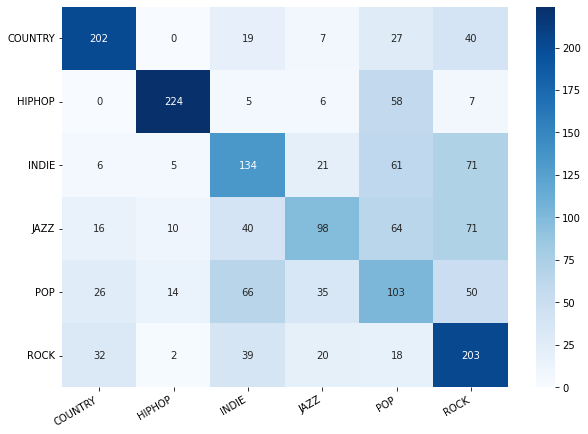

In [61]:
plt.rcParams["figure.figsize"] = (10,7)
cm = confusion_matrix(target_values, predictions)
df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
show_confusion_matrix(df_cm)

## Predict on texts
 

In [62]:
test_df.columns[3:]

Index(['COUNTRY', 'HIPHOP', 'INDIE', 'JAZZ', 'POP', 'ROCK'], dtype='object')

In [65]:
# testing
example = test_df['lyric_pp'][0]
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(train_df.columns[3:].to_list()[int(np.argmax(final_output, axis=1))])

POP
